In [1]:
import os
import glob

import polars as pl
import polars.selectors as cs

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import lightgbm as lgbm #gradient boosting machine learning algorithms
#import xgboost as xgb #gradient boosting machine learning algorithms
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import cohen_kappa_score #This imports the Cohen's kappa score, a statistical measure used to assess inter-rater agreement for classification problems.

import matplotlib.pyplot as plt 
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

from matplotlib.ticker import PercentFormatter  # To format the x-axis as percentages

In [2]:
#Helps to print/show multiple variables at a time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#If you want to set this behavior for all instances of Jupyter (Notebook and Console), simply create a file ~/.ipython/profile_default/ipython_config.py with the following lines:
#c = get_config()
# Run all nodes interactively
#c.InteractiveShell.ast_node_interactivity = "all"

Load Data

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
data_dict = pd.read_csv('data/data_dictionary.csv')


In [5]:
train.columns = train.columns.str.lower().str.replace(r'\W+', '_', regex=True)
test.columns = test.columns.str.lower().str.replace(r'\W+', '_', regex=True)

In [ ]:
train.head()
test.head()

In [6]:
#data_dict.info()
data_dict.head(40)
#Children's Global Assessment Scale	CGAS-CGAS_Score	Children's Global Assessment Scale Score	int	NaN	NaN
#Physical Activity Questionnaire (Adolescents)	PAQ_A-PAQ_A_Total	Activity Summary Score (Adolescents)	float	NaN	NaN
#Physical Activity Questionnaire (Children)	PAQ_C-PAQ_C_Total	Activity Summary Score (Children)	float	NaN	NaN

#Questionaire: PCIAT-PCIAT_01 - PCIAT-PCIAT_20

#Parent-Child Internet Addiction Test	PCIAT-PCIAT_Total	Total Score	int	NaN	Severity Impairment Index: 0-30=None; 31-49=Mi..
#Internet Use	PreInt_EduHx-computerinternet_hoursday	Hours of using computer/internet	categorical int	0,1,2,3	0=Less than 1h/day, 1=Around 1h/day, 2=Around ..

#Sleep Disturbance Scale	SDS-SDS_Total_Raw	Total Raw Score	int	NaN	NaN
#Sleep Disturbance Scale	SDS-SDS_Total_T	Total T-Score	int	NaN	NaN

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
5,Children's Global Assessment Scale,CGAS-CGAS_Score,Children's Global Assessment Scale Score,int,NaN,NaN
6,Physical Measures,Physical-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
7,Physical Measures,Physical-BMI,Body Mass Index (kg/m^2),float,NaN,NaN
8,Physical Measures,Physical-Height,Height (in),float,NaN,NaN
9,Physical Measures,Physical-Weight,Weight (lbs),float,NaN,NaN


In [7]:
#test.describe()
#train.describe()
test.info()
train.info()
train[~train['sii'].isnull()].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   basic_demos_enroll_season               20 non-null     object 
 2   basic_demos_age                         20 non-null     int64  
 3   basic_demos_sex                         20 non-null     int64  
 4   cgas_season                             10 non-null     object 
 5   cgas_cgas_score                         8 non-null      float64
 6   physical_season                         14 non-null     object 
 7   physical_bmi                            13 non-null     float64
 8   physical_height                         13 non-null     float64
 9   physical_weight                         13 non-null     float64
 10  physical_waist_circumference            5 non-null      float64


In [8]:
train.sii.isnull().sum()
print(1224/3960*100,"% empty sii")

1224

30.909090909090907 % empty sii


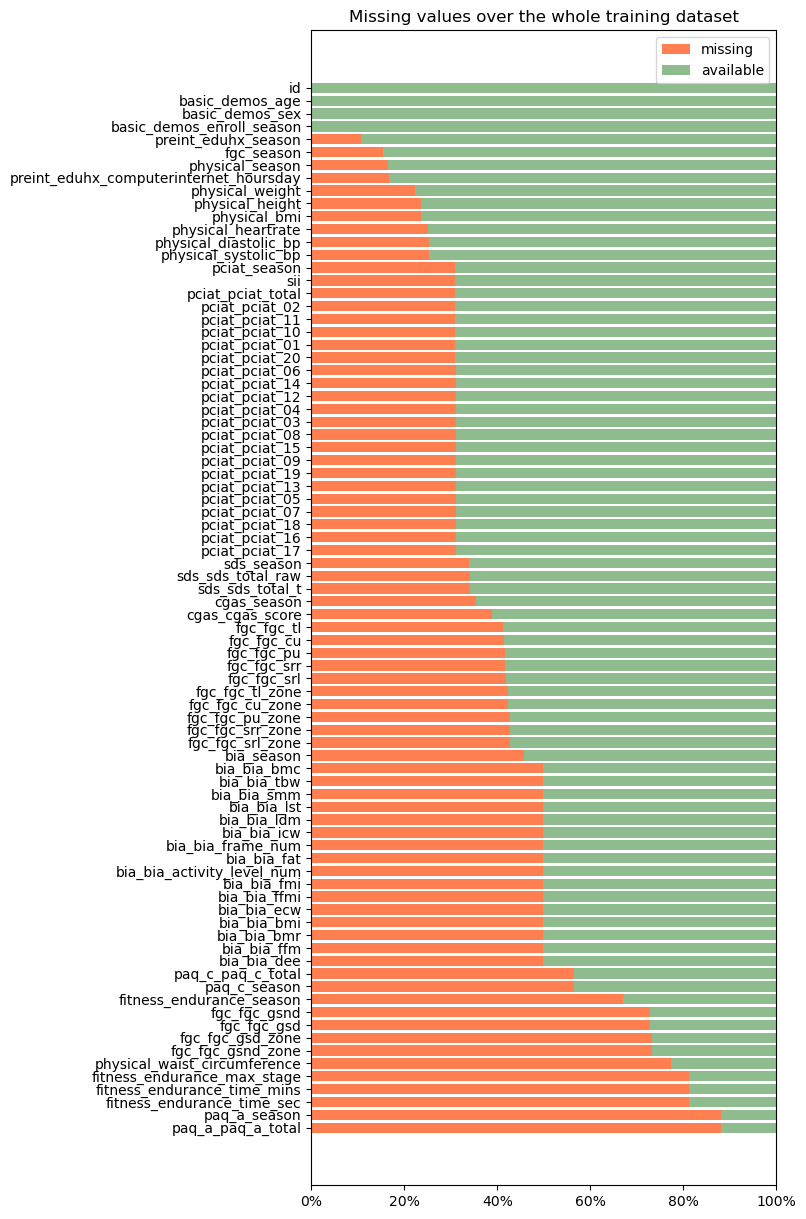

In [9]:
# Count missing values and calculate the null ratio for each column
missing_count = (
    pd.DataFrame({
        'feature': train.columns,  # Get column names
        'null_count': train.isnull().sum()  # Count missing values
    })
    .sort_values(by='null_count', ascending=False)  # Sort by the count of missing values
)

# Add the ratio of missing values
missing_count['null_ratio'] = missing_count['null_count'] / len(train)

# Plot missing values
plt.figure(figsize=(6, 15))
plt.title('Missing values over the whole training dataset')

# Plot bars for missing and available data
plt.barh(np.arange(len(missing_count)), missing_count['null_ratio'], color='coral', label='missing')
plt.barh(np.arange(len(missing_count)), 
         1 - missing_count['null_ratio'], 
         left=missing_count['null_ratio'], 
         color='darkseagreen', label='available')

# Set y-ticks to display feature names
plt.yticks(np.arange(len(missing_count)), missing_count['feature'])

# Format x-axis as percentage
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

# Set limits for x-axis
plt.xlim(0, 1)

# Show legend and plot
plt.legend()
plt.show();

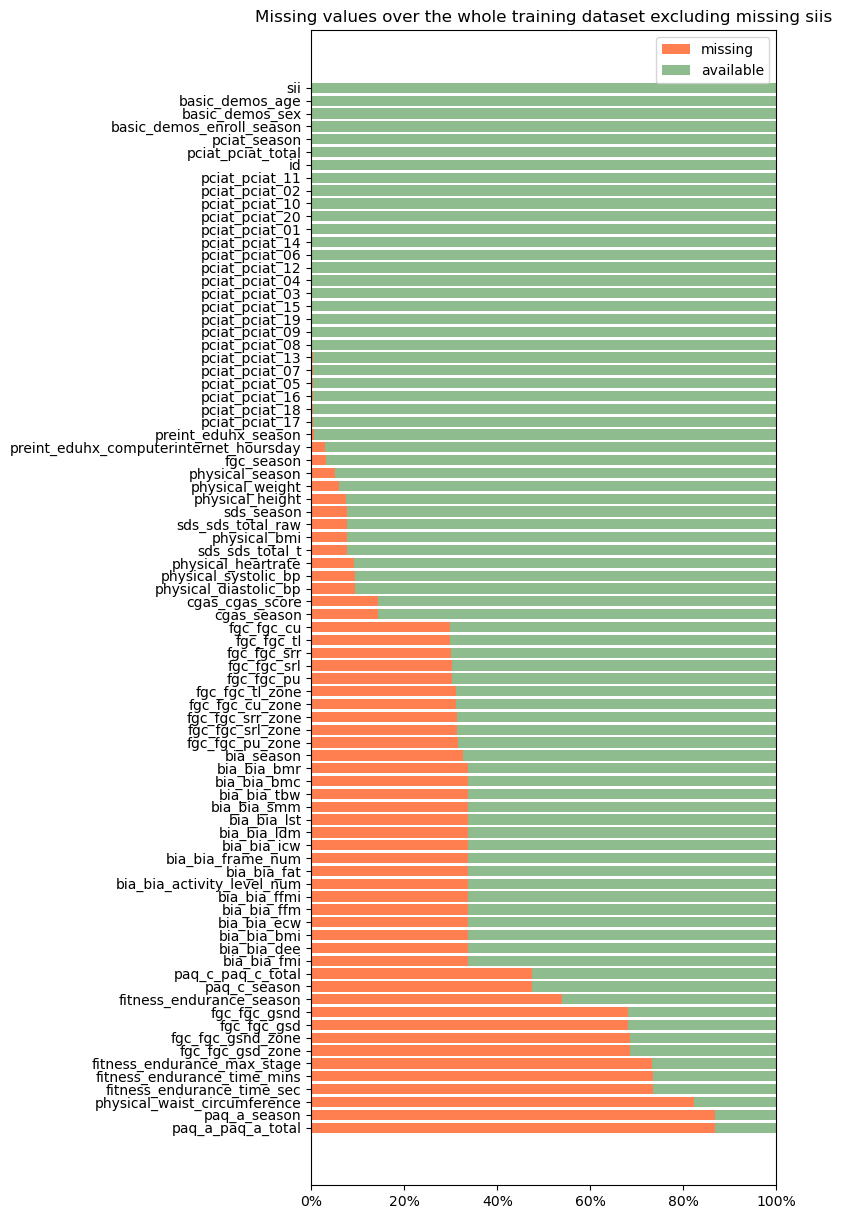

In [10]:
tmp = train[train['sii'].notnull()]
# Count missing values and calculate the null ratio for each column
missing_count2 = (
    pd.DataFrame({
        'feature': tmp.columns,  # Get column names
        'null_count': tmp.isnull().sum()  # Count missing values
    })
    .sort_values(by='null_count', ascending=False)  # Sort by the count of missing values
)

# Add the ratio of missing values
missing_count2['null_ratio'] = missing_count2['null_count'] / len(tmp)

# Plot missing values
plt.figure(figsize=(6, 15))
plt.title('Missing values over the whole training dataset excluding missing siis')

# Plot bars for missing and available data
plt.barh(np.arange(len(missing_count2)), missing_count2['null_ratio'], color='coral', label='missing')
plt.barh(np.arange(len(missing_count2)), 
         1 - missing_count2['null_ratio'], 
         left=missing_count2['null_ratio'], 
         color='darkseagreen', label='available')

# Set y-ticks to display feature names
plt.yticks(np.arange(len(missing_count2)), missing_count2['feature'])

# Format x-axis as percentage
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

# Set limits for x-axis
plt.xlim(0, 1)

# Show legend and plot
plt.legend()
plt.show();

In [11]:
#delete unused arguments

del tmp, missing_count, missing_count2

In [57]:
data_dict[0:49]

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
5,Children's Global Assessment Scale,CGAS-CGAS_Score,Children's Global Assessment Scale Score,int,NaN,NaN
6,Physical Measures,Physical-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
7,Physical Measures,Physical-BMI,Body Mass Index (kg/m^2),float,NaN,NaN
8,Physical Measures,Physical-Height,Height (in),float,NaN,NaN
9,Physical Measures,Physical-Weight,Weight (lbs),float,NaN,NaN


In [38]:
#pd.set_option('display.max_rows', None)
#before EDA, check datatype matching of variables in train df
train.describe()
#train.dtypes


,basic_demos_age,cgas_cgas_score,physical_bmi,physical_height,physical_weight,physical_waist_circumference,physical_diastolic_bp,physical_heartrate,physical_systolic_bp,fitness_endurance_max_stage,fitness_endurance_time_mins,fitness_endurance_time_sec,fgc_fgc_cu,fgc_fgc_gsnd,fgc_fgc_gsd,fgc_fgc_pu,fgc_fgc_srl,fgc_fgc_srr,fgc_fgc_tl,bia_bia_activity_level_num,bia_bia_bmc,bia_bia_bmi,bia_bia_bmr,bia_bia_dee,bia_bia_ecw,bia_bia_ffm,bia_bia_ffmi,bia_bia_fmi,bia_bia_fat,bia_bia_frame_num,bia_bia_icw,bia_bia_ldm,bia_bia_lst,bia_bia_smm,bia_bia_tbw,paq_a_paq_a_total,paq_c_paq_c_total,pciat_pciat_total,sds_sds_total_raw,sds_sds_total_t
count,3960.000000,2421.000000,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000,743.000000,740.000000,740.000000,2322.000000,1074.000000,1074.000000,2310.000000,2305.000000,2307.000000,2324.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.00000,1991.000000,1991.000000,1991.000000,475.000000,1721.000000,2736.000000,2609.000000,2606.000000
mean,10.433586,65.454771,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074,4.989233,7.370270,27.581081,11.259690,22.420438,23.518622,5.579654,8.694924,8.805635,9.252775,2.651431,6.719826,19.367048,1237.018187,2064.693747,20.825346,74.021708,15.030554,4.336495,16.855020,1.745354,33.173380,20.02299,67.301883,34.389466,53.998726,2.178853,2.589550,27.896199,41.088923,57.763622
std,3.574648,22.341862,5.113934,7.473764,44.569040,5.567287,13.611226,13.665196,17.061225,2.014072,3.189662,17.707751,11.807781,10.833995,11.148951,7.390161,3.429301,3.422167,2.988863,1.028267,92.586325,5.047848,1872.383246,2836.246272,73.266287,199.433753,5.792505,6.356402,199.372119,0.680635,56.272346,70.21561,108.705918,84.050607,129.362539,0.849476,0.783937,20.338853,10.427433,13.196091
min,5.000000,25.000000,0.000000,33.000000,0.000000,18.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-7.789610,0.048267,813.397000,1073.450000,1.789450,28.900400,7.864850,-194.163000,-8745.080000,1.000000,14.489000,4.63581,23.620100,4.655730,20.589200,0.660000,0.580000,0.000000,17.000000,38.000000
25%,8.000000,59.000000,15.869350,50.000000,57.200000,23.000000,61.000000,72.000000,107.000000,4.000000,6.000000,12.750000,3.000000,15.100000,16.200000,0.000000,7.000000,7.000000,7.000000,2.000000,2.966905,15.913600,1004.710000,1605.785000,11.109550,49.278100,13.408000,2.306915,8.602395,1.000000,24.463500,12.98315,45.204100,21.141550,35.887000,1.490000,2.020000,12.000000,33.000000,47.000000
50%,10.000000,65.000000,17.937682,55.000000,77.000000,26.000000,68.000000,81.000000,114.000000,5.000000,7.000000,28.000000,9.000000,20.050000,21.200000,3.000000,9.000000,9.000000,10.000000,3.000000,3.922720,17.966500,1115.380000,1863.980000,15.928000,61.066200,14.092500,3.698630,16.174600,2.000000,28.855800,16.43880,56.996400,27.415100,44.987000,2.010000,2.540000,26.000000,39.000000,55.000000
75%,13.000000,75.000000,21.571244,62.000000,113.800000,30.000000,76.000000,90.500000,125.000000,6.000000,9.000000,43.000000,15.750000,26.600000,28.175000,9.000000,11.000000,11.000000,12.000000,3.000000,5.460925,21.461100,1310.360000,2218.145000,25.162200,81.833800,15.430950,5.987690,30.273100,2.000000,35.475700,22.16760,77.105650,38.179400,60.271050,2.780000,3.160000,41.000000,46.000000,64.000000
max,22.000000,999.000000,59.132048,78.500000,315.000000,50.000000,179.000000,138.000000,203.000000,28.000000,20.000000,59.000000,115.000000,124.000000,123.800000,51.000000,21.700000,21.000000,22.000000,5.000000,4115.360000,53.924300,83152.200000,124728.000000,3233.000000,8799.080000,217.771000,28.251500,153.820000,3.000000,2457.910000,3108.17000,4683.710000,3607.690000,5690.910000,4.710000,4.790000,93.000000,96.000000,100.000000


In [34]:
#change unmatching dtypes

for col in train.columns:
    if col.startswith('fgc') and col.endswith('zone'):
        # Convert to categorical if it starts with 'fgc' and ends with 'zone'
        train[col] = train[col].astype('category')
    elif col.startswith('pciat_pciat_') and col[-2:].isdigit():
        # Convert to categorical if it starts with 'pciat_pciat_' and ends with a number
        train[col] = train[col].astype('category')
    elif col == "basic_demos_sex":
        # Convert 'basic_demos_sex' to categorical
        train[col] = train[col].astype('category')
    elif col == "sii":
        # Convert 'basic_demos_sex' to categorical
        train[col] = train[col].astype('category')
    elif col == "preint_eduhx_computerinternet_hoursday":
        # Convert 'basic_demos_sex' to categorical
        train[col] = train[col].astype('category')
        


In [37]:
#train.dtypes

In [35]:
#train.columns.tolist()

<Axes: >

Text(0.5, 1.0, 'Histogram of basic_demos_enroll_season')

Text(0.5, 0, 'basic_demos_enroll_season')

Text(0, 0.5, 'Frequency')

<Axes: >

Text(0.5, 1.0, 'Histogram of basic_demos_age')

Text(0.5, 0, 'basic_demos_age')

Text(0, 0.5, 'Frequency')

<Axes: >

Text(0.5, 1.0, 'Histogram of basic_demos_sex')

Text(0.5, 0, 'basic_demos_sex')

Text(0, 0.5, 'Frequency')

<Axes: >

Text(0.5, 1.0, 'Histogram of bia_season')

Text(0.5, 0, 'bia_season')

Text(0, 0.5, 'Frequency')

<Axes: >

Text(0.5, 1.0, 'Histogram of bia_bia_activity_level_num')

Text(0.5, 0, 'bia_bia_activity_level_num')

Text(0, 0.5, 'Frequency')

<Axes: >

Text(0.5, 1.0, 'Histogram of bia_bia_bmc')

Text(0.5, 0, 'bia_bia_bmc')

Text(0, 0.5, 'Frequency')

<Axes: >

Text(0.5, 1.0, 'Histogram of bia_bia_bmi')

Text(0.5, 0, 'bia_bia_bmi')

Text(0, 0.5, 'Frequency')

<Axes: >

Text(0.5, 1.0, 'Histogram of bia_bia_bmr')

Text(0.5, 0, 'bia_bia_bmr')

Text(0, 0.5, 'Frequency')

<Axes: >

Text(0.5, 1.0, 'Histogram of bia_bia_dee')

Text(0.5, 0, 'bia_bia_dee')

Text(0, 0.5, 'Frequency')

<Axes: >

Text(0.5, 1.0, 'Histogram of bia_bia_ecw')

Text(0.5, 0, 'bia_bia_ecw')

Text(0, 0.5, 'Frequency')

<Axes: >

Text(0.5, 1.0, 'Histogram of bia_bia_ffm')

Text(0.5, 0, 'bia_bia_ffm')

Text(0, 0.5, 'Frequency')

<Axes: >

Text(0.5, 1.0, 'Histogram of bia_bia_ffmi')

Text(0.5, 0, 'bia_bia_ffmi')

Text(0, 0.5, 'Frequency')

<Axes: >

Text(0.5, 1.0, 'Histogram of bia_bia_fmi')

Text(0.5, 0, 'bia_bia_fmi')

Text(0, 0.5, 'Frequency')

<Axes: >

Text(0.5, 1.0, 'Histogram of bia_bia_fat')

Text(0.5, 0, 'bia_bia_fat')

Text(0, 0.5, 'Frequency')

<Axes: >

Text(0.5, 1.0, 'Histogram of bia_bia_frame_num')

Text(0.5, 0, 'bia_bia_frame_num')

Text(0, 0.5, 'Frequency')

<Axes: >

Text(0.5, 1.0, 'Histogram of bia_bia_icw')

Text(0.5, 0, 'bia_bia_icw')

Text(0, 0.5, 'Frequency')

<Axes: >

Text(0.5, 1.0, 'Histogram of bia_bia_ldm')

Text(0.5, 0, 'bia_bia_ldm')

Text(0, 0.5, 'Frequency')

<Axes: >

Text(0.5, 1.0, 'Histogram of bia_bia_lst')

Text(0.5, 0, 'bia_bia_lst')

Text(0, 0.5, 'Frequency')

<Axes: >

Text(0.5, 1.0, 'Histogram of bia_bia_smm')

Text(0.5, 0, 'bia_bia_smm')

Text(0, 0.5, 'Frequency')

<Axes: >

Text(0.5, 1.0, 'Histogram of bia_bia_tbw')

Text(0.5, 0, 'bia_bia_tbw')

Text(0, 0.5, 'Frequency')

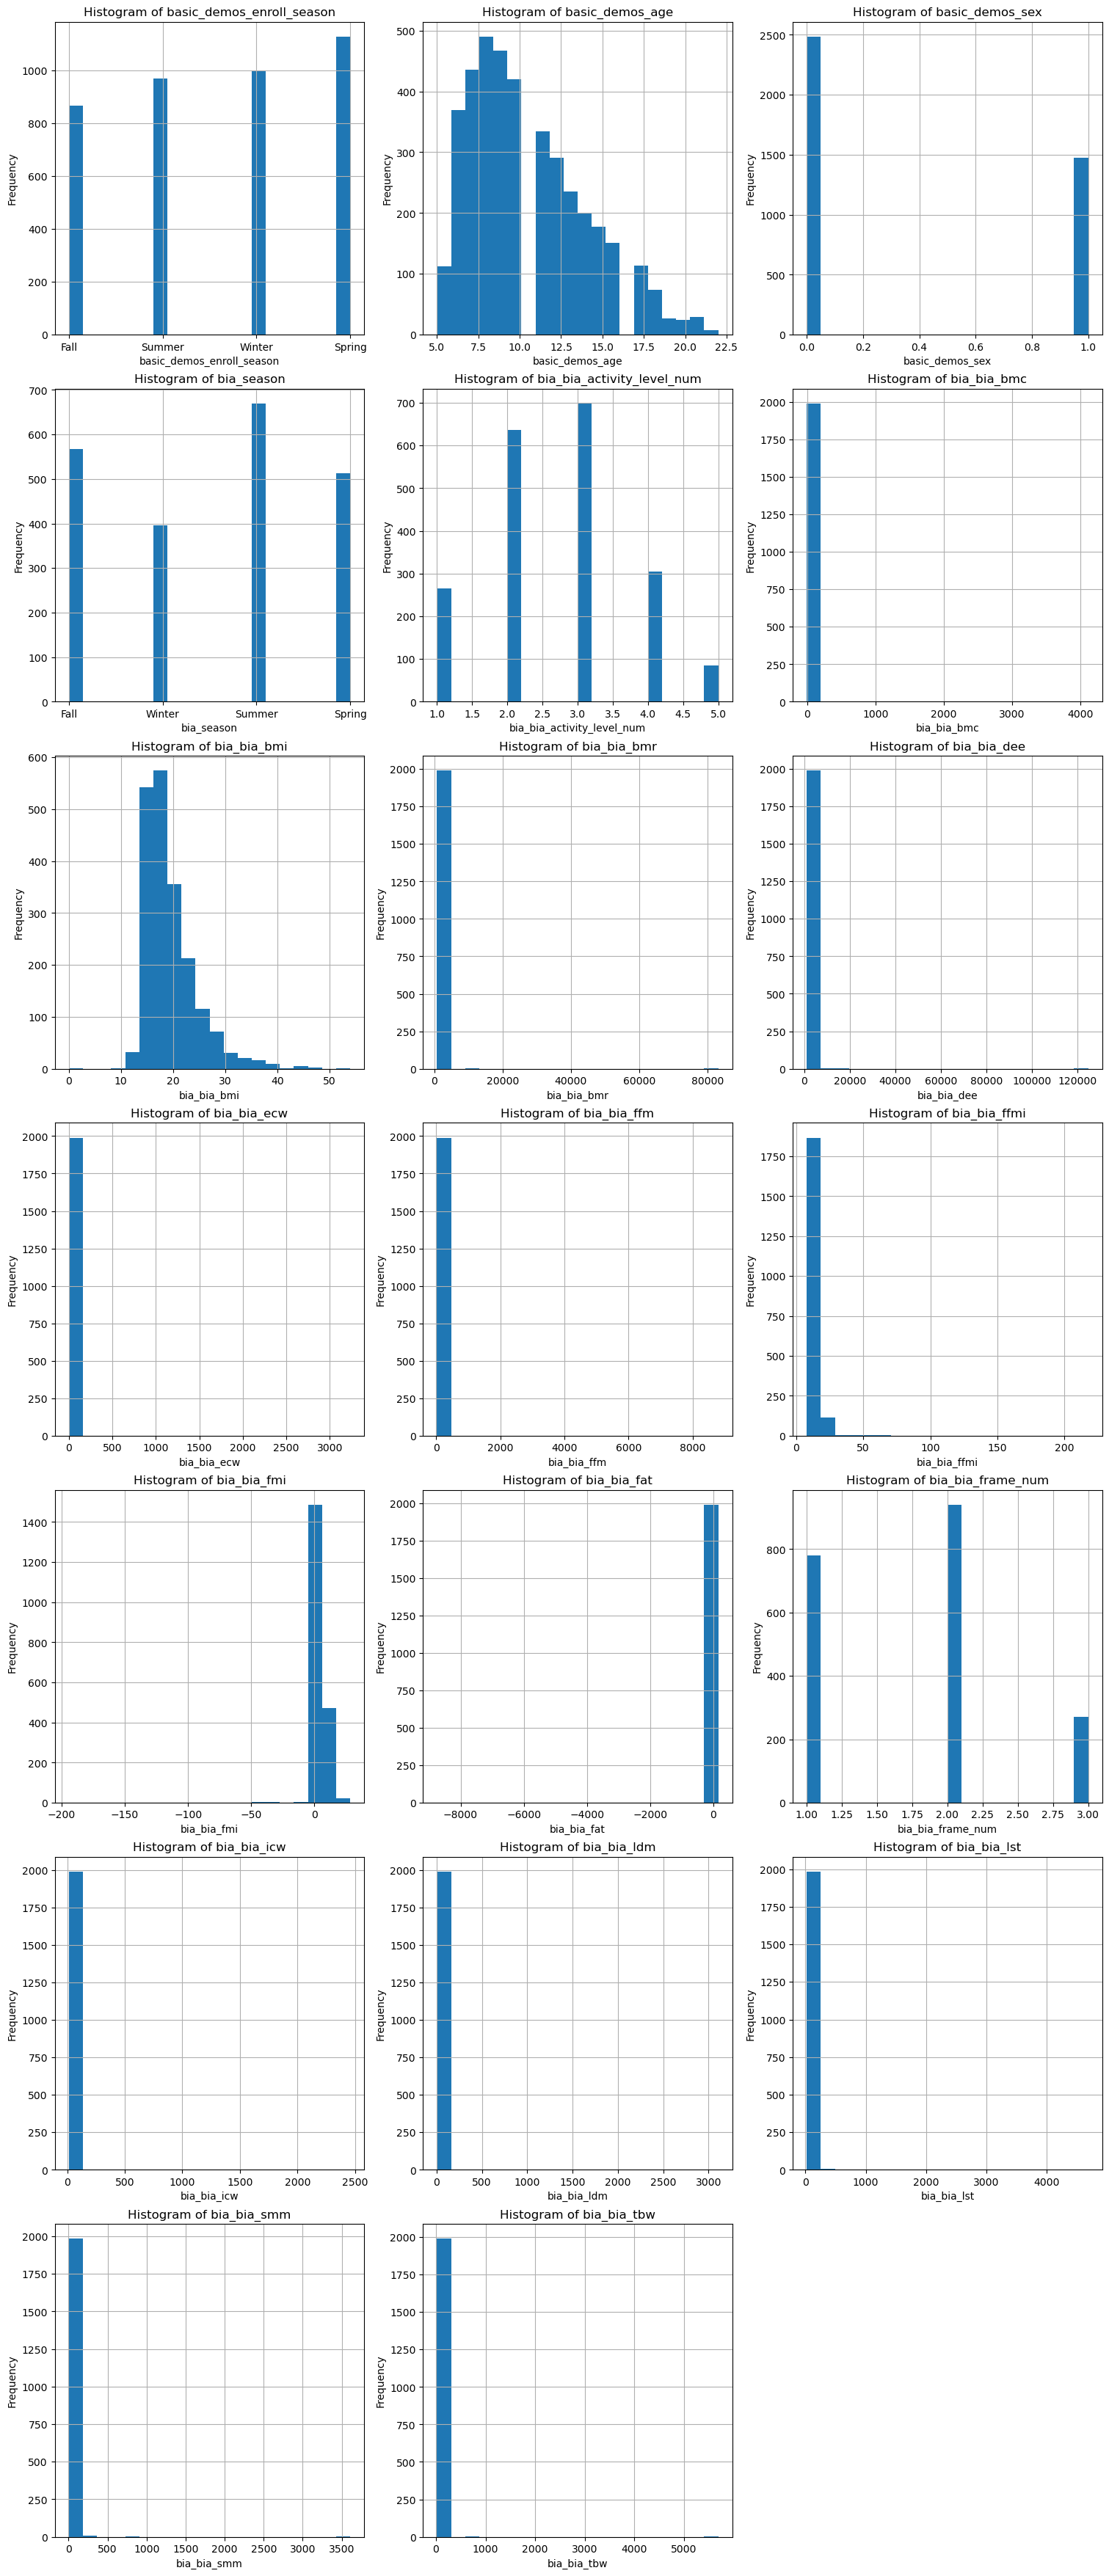

In [56]:
import matplotlib.pyplot as plt

# Filter for columns starting with 'basic'
prefixes = ('basic', 'bia', 'PAQ')

# Filter columns that start with any of the prefixes
filtered_columns = [col for col in train.columns if col.startswith(prefixes)]

# Determine the number of rows and columns for the grid
cols = 3
rows = -(-len(filtered_columns) // cols)  # Ceiling division to get the number of rows

# Create a single figure with multiple subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), constrained_layout=True)
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot histograms for each 'basic' column
for i, col in enumerate(filtered_columns):
    train[col].dropna().hist(bins=20, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any remaining empty subplots
for i in range(len(filtered_columns), len(axes)):
    axes[i].set_visible(False)

# Display the plot
plt.show()


In [72]:
train.bia_bia_bmc.range()
plt.figure(figsize=(8, 6))  # Specify the size of the figure
d.dropna().hist(bins=5)
plt.title(f'Histogram of {d}')
plt.xlabel(d)
plt.ylabel('Frequency')
plt.show()

AttributeError: 'Series' object has no attribute 'range'